# Actividad
Planeas irte de viaje a Honolulu y decides hacer un análisis exploratorio de la data climática de la isla. Para comenzar, utiliza Python y SQLAlchemy para hacer tus análisis de clima y exploración de las tablas y los datos contenidos en la base de datos. Todos los análisis se deben completar utilizando SQLAlchemy, Queries ORM, y, si decides ir por la extra milla, Pandas y Matplotlib. Utiliza clases y OOP como guía para el desarrollo; no es necesario imprimir en pantalla, basta con la creación de las clases, funciones o métodos correspondientes.
- Escoge una fecha de inicio y de finalización del viaje. Asegúrate que la duración del mismo sea entre 3 a 15 días.
- Utiliza SQLAlchemy create_engine para conectarte a la base de datos Honolulu.SQLITE
- Utiliza SQLAlchemy automap_base() para reflejar las tablas en clases y guardar una referencia a esas clases llamadas Station y Measurement.

**Se ecoje la fecha 2016-11-25 a 2016-12-05**<br>
Se realizan los calculos a partir de la fecha inicial *2016-11-25*

# Creación de la conexión SQLite
**En este ejemplo la creación se realiza permitiendo que automap_base() asuma los modelos de BD**. <br> *En el código se especifican por medio de clases* 

In [1]:
from sqlalchemy import create_engine, func
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base
from datetime import datetime
import dateutil.relativedelta
import logging



DATABASE_ROUTE = "sqlite:///hawaii.sqlite"
START_DATE = '2016-11-25'
END_DATE = '2016-12-05'


Base = automap_base()
engine = create_engine(DATABASE_ROUTE)
Base.prepare(engine, reflect=True)
session = Session(engine)

# mapped classes created
Measurement = Base.classes.measurement
Station = Base.classes.station

**Creación del proceso unificado de Dataframes (class)**
- Se crean metodos para realizar diferentes procesos dentro de los query results según se requiera.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt


class HonoluluDf:
    """A class used to represent an Animal
    Args:
    ----------
    table_result : list
        a tuple list with the db result.
    index_field : str
        field from the db to create the index (can't be the same 'table_vale').
    table_value : str
        field from the db to do the operations (avg, max, min etc..)

    Methods
    -------
    get_df:
        generate a Data frame object.
    get_scatter_plot_data:
        generate a plot type scatter for the given table
    get_hist_plot_data:
        generate a hist plot for the given table
    """
    def __init__(self, table_result, index_field, table_value):
        self.table_result = table_result
        self.table_value = str(table_value)
        self.index_field = index_field

        self.df = pd.DataFrame(self.table_result).sort_values(by=[self.index_field])

    def __str__(self):
        return self.df.__str__()

    def get_df(self):
        return self.df

    def get_scatter_plot_data(self):
        self.df.plot(x=self.index_field, y=self.table_value, kind='scatter')
        plt.show()

    def get_hist_plot_data(self):
        self.df.hist(bins=12)
        plt.show()

# Diseña un QUERY para calcular el número total de estaciones.

In [3]:
def get_count(table_value):
    """
    Parameters
    ----------
        table_value: table from Sqlalchemy model.
            Model from Sqlalchemy table and module in
            format 'module.table'.
    Returns
    -------
        Int: with count of all rows from the 'module.table'.
    """
    try:
        return session.query(table_value).count()

    except Exception as exc:
        logging.warning(exc)
        
        
print(get_count(Station.station))

9


# Diseña un QUERY para encontrar cuáles son las estaciones más activas:
- Enumera las estaciones y conteo de observaciones en orden descendente.
- ¿Cuál estación tiene el número mayor de observaciones?

In [4]:
def get_groupBy(table_value):
    """
    Parameters
    ----------
        table_value: table from Sqlalchemy model.
            Model from Sqlalchemy table and module
            in format 'module.table'.
    Returns
    -------
        Int: with count of all rows from the 'module.table'.
    """
    try:
        return session.query(func.row_number()
                            .over(order_by=func.count(table_value).label(str(table_value)+'_numb').desc())
                            .label("row_number"),
                            table_value,
                            func.count(table_value) \
                            .label(str(table_value)+'_numb')).group_by(table_value).all()

    except Exception as exc:
        logging.warning(exc)

        
print(get_groupBy(Measurement.station))

[(1, 'USC00519281', 2772), (2, 'USC00519397', 2724), (3, 'USC00513117', 2709), (4, 'USC00519523', 2669), (5, 'USC00516128', 2612), (6, 'USC00514830', 2202), (7, 'USC00511918', 1979), (8, 'USC00517948', 1372), (9, 'USC00518838', 511)]


# Diseña un QUERY para obtener los últimos 12 meses de mediciones de temperatura (tobs)
- Filtra por estaciones con el mayor número de observaciones.
- [OPCIONAL] Grafica los resultados como un histograma con bins=12.

<font color='green'>*Se crea una función generica para obtenér igualmente el query de precipitaciones*</font>

In [12]:
def get_measurement_date_partitioned_from(column: str = None,
                                          end_date: str = None,
                                          months_to_decrease: int = None):
    """
    Parameters
    ----------
        column: str
            set 'tobs' or 'prcp' column.
        end_date: str
            determine the final date to get data.
        months_to_decrease: Int
            number of months to calculate from which
            date do filter.
    Returns
    -------
        list: with the values of the query
    """

    try:
        source_dict = {'prcp': Measurement.prcp,
                       'tobs': Measurement.tobs}

        if column is None or column not in source_dict:
            return [('error', 'column error')]

        table_lable = source_dict[column]
        lable_name = column

        trfm_date = datetime.strptime(end_date, "%Y-%m-%d")
        start_date = trfm_date - dateutil.relativedelta.relativedelta(months=months_to_decrease)

        return session.query(Measurement.date.label('date'),
                                        table_lable.label(str(lable_name))) \
            .filter(Measurement.date > start_date.strftime("%Y-%m-%d"),
                    Measurement.date < end_date) \
            .order_by(table_lable.label(str(lable_name)).desc()).all()

    except Exception as exc:
        logging.info(exc)
        
        
prcp_result = get_measurement_date_partitioned_from(column='prcp', 
                                                    end_date=END_DATE, 
                                                    months_to_decrease=12)

tobs_result = get_measurement_date_partitioned_from(column='tobs', 
                                                    end_date=END_DATE, 
                                                    months_to_decrease=12)

# Dataframes

**Proceso: **
- Realizar los queries para las tablas que requieren Dataframes
- Se indican los procedimientos.
- Carga los resultados del QUERY en un Pandas DataFrame (el index se especifica en la clase junto con su orden).
- Grafica los resultados utilizando el método plot de DataFrame.
- Utiliza Pandas para imprimir el sumario de estadísticas para la data de precipitación.
- Grafica los resultados como un histograma con bins=12.

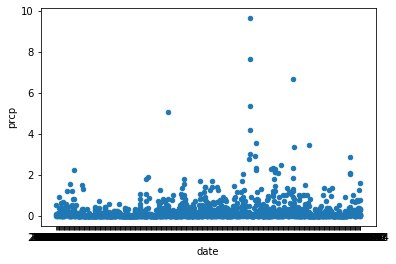

              prcp
count  2050.000000
mean      0.180327
std       0.506908
min       0.000000
25%       0.000000
50%       0.020000
75%       0.150000
max       9.640000



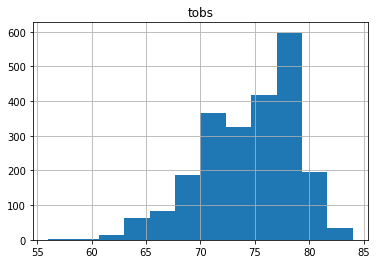

              tobs
count  2288.000000
mean     74.332605
std       4.369764
min      56.000000
25%      71.000000
50%      75.000000
75%      78.000000
max      84.000000


In [21]:
#Creación de los objetos DF de cada columna 'prcp' y 'tobs'
honolulu_df_prcp = HonoluluDf(prcp_result, 'date', 'prcp')
honolulu_df_tobs = HonoluluDf(tobs_result, 'date', 'tobs')


# Creación de el scatter plot y un sumario con las estadisticas de prcp
honolulu_df_prcp.get_scatter_plot_data()

df_prcp = honolulu_df_prcp.get_df()
print(f"{df_prcp.describe()}\n")


# Creación de el scatter plot y un sumario con las estadisticas de prcp
honolulu_df_tobs.get_hist_plot_data()

df_tobs = honolulu_df_tobs.get_df()
print(f"{df_tobs.describe()}")
